In [94]:
# generic modules
import datetime, os
import itertools
import time
import pickle

# append working folder
import sys
# working_folder = './gdrive/My Drive/Teaching/CS4305TU Applied Machine Learning/SWMM/'
# sys.path.append(working_folder)


# basic data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
# import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import backend as K

# sklearn helper functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import scipy
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib

In [10]:
df_p_t = pd.read_csv("../data/raw/processed/tweets_protests_time_lag.csv")
df_p_t_state = pd.read_csv("../data/raw/processed/state_tp_time.csv")
df = df_p_t[['date','tweet_count', 'protest_count']]
df_state = df_p_t_state[['date','tweet_count', 'protest_count', "state"]]

df['state'] = 'USA'
df = pd.concat([df_state, df])
df.date = pd.to_datetime(df.date)

df.index = df.date
df = df.drop("date", axis=1)

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
df

,tweet_count,protest_count,state
date,,,
2020-05-29,24.0,1,AK
2020-05-30,33.0,4,AK
2020-05-31,46.0,2,AK
2020-06-01,27.0,6,AK
2020-06-02,41.0,4,AK
...,...,...,...
2020-11-05,1389.0,11,USA
2020-11-06,1299.0,11,USA
2020-11-07,1798.0,29,USA


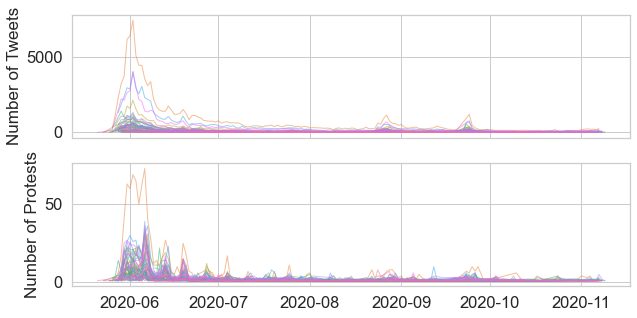

In [18]:
# tweets_geo = gpd.read_file("tweets_gdf_fs.geojson", driver="GeoJSON")
sns.set(style ="whitegrid", font_scale=1.5)
# preprocess protest and tweet data
# tweets_geo['created_at'] = pd.to_datetime(tweets_geo['created_at'])
# tweets_geo['tweet_count'] = 1
# tweets_geo['created_at_day'] = pd.to_datetime(tweets_geo['created_at'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')

# df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'], format='%Y-%m-%d')
fig, ax = plt.subplots(2,1, figsize=(10,5))
g1 = sns.lineplot(ax = ax[0], data = df[df['state']!="USA"], x = 'date', y = 'tweet_count', linewidth = 1, hue="state", alpha=0.5)
g2 = sns.lineplot(ax = ax[1], data = df[df['state']!="USA"], x = 'date', y = 'protest_count', linewidth = 1, hue="state", alpha=0.5)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("Number of Tweets", fontsize=17)
ax[1].set_ylabel("Number of Protests", fontsize=17)
ax[0].set(xticklabels=[])
ax[0].set(xlabel=None)
g1.legend_.remove()
g2.legend_.remove()

# ax[0].set_yscale("log")
# ax[1].set_yscale("log")

# ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Change in voter turnout", fontsize=14)
# ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Change in voter turnout", fontsize=14)

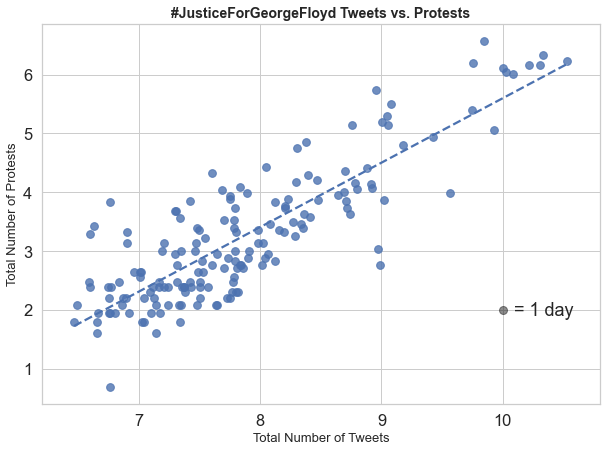

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.852
R^2 score = 0.726


In [19]:
fig, ax = plt.subplots(figsize=(10,7))

X = np.log(df[df['state']=="USA"]['tweet_count'][:, None])
y = np.log(df[df['state']=="USA"]['protest_count'][:, None])

# ax.set_yscale("log")
# ax.set_xscale("log")
ax = sns.regplot(data = df[df['state']=="USA"], x = X, y = y, scatter_kws={"s": 60}, ci=False)
# ax = sns.regplot(data = df_p_t, x = 'tweet_count', y = 'protest_count', scatter_kws={"s": 60}, ci=False)

ax.set(xlim=(6.2, 10.8))
# ax.set_xlim(2000,)

# ax.set_xlim(auto=True)

ax.lines[0].set_linestyle("--")

ax.set_xlabel("Total Number of Tweets", fontsize=13)
ax.set_ylabel("Total Number of Protests", fontsize=13)
ax.set_title("#JusticeForGeorgeFloyd Tweets vs. Protests", fontsize=14, fontweight="bold")

# regression metrics
slope, inercept, r_value, p_value, std_err = scipy.stats.linregress(X.reshape(-1), y[:, None].reshape(-1))

# annotations
style = dict(size=11)
# ax.annotate(f"Pearson Correlation = {r_value.round(3)}", xy=(6.5, 6), xytext=(6.5, 6), **style)
# ax.annotate(f"r2 = {(r_value**2).round(3)}", xy=(6.5, 5.7), xytext=(6.5, 5.7), **style)

# legend
ax.plot(10, 2, 'o',
        ms=8, mec='k', color="k", alpha=0.5)

ax.annotate(f" = 1 day", xy=(10.05, 1.9), xytext=(10.05, 1.9))


plt.show()

print("-"*110)
print(f"Pearson Correlation = {r_value.round(3)}")
print(f"R^2 score = {(r_value**2).round(3)}")

## Correlated Time Series Analysis

In [54]:
import warnings
warnings.filterwarnings("ignore")

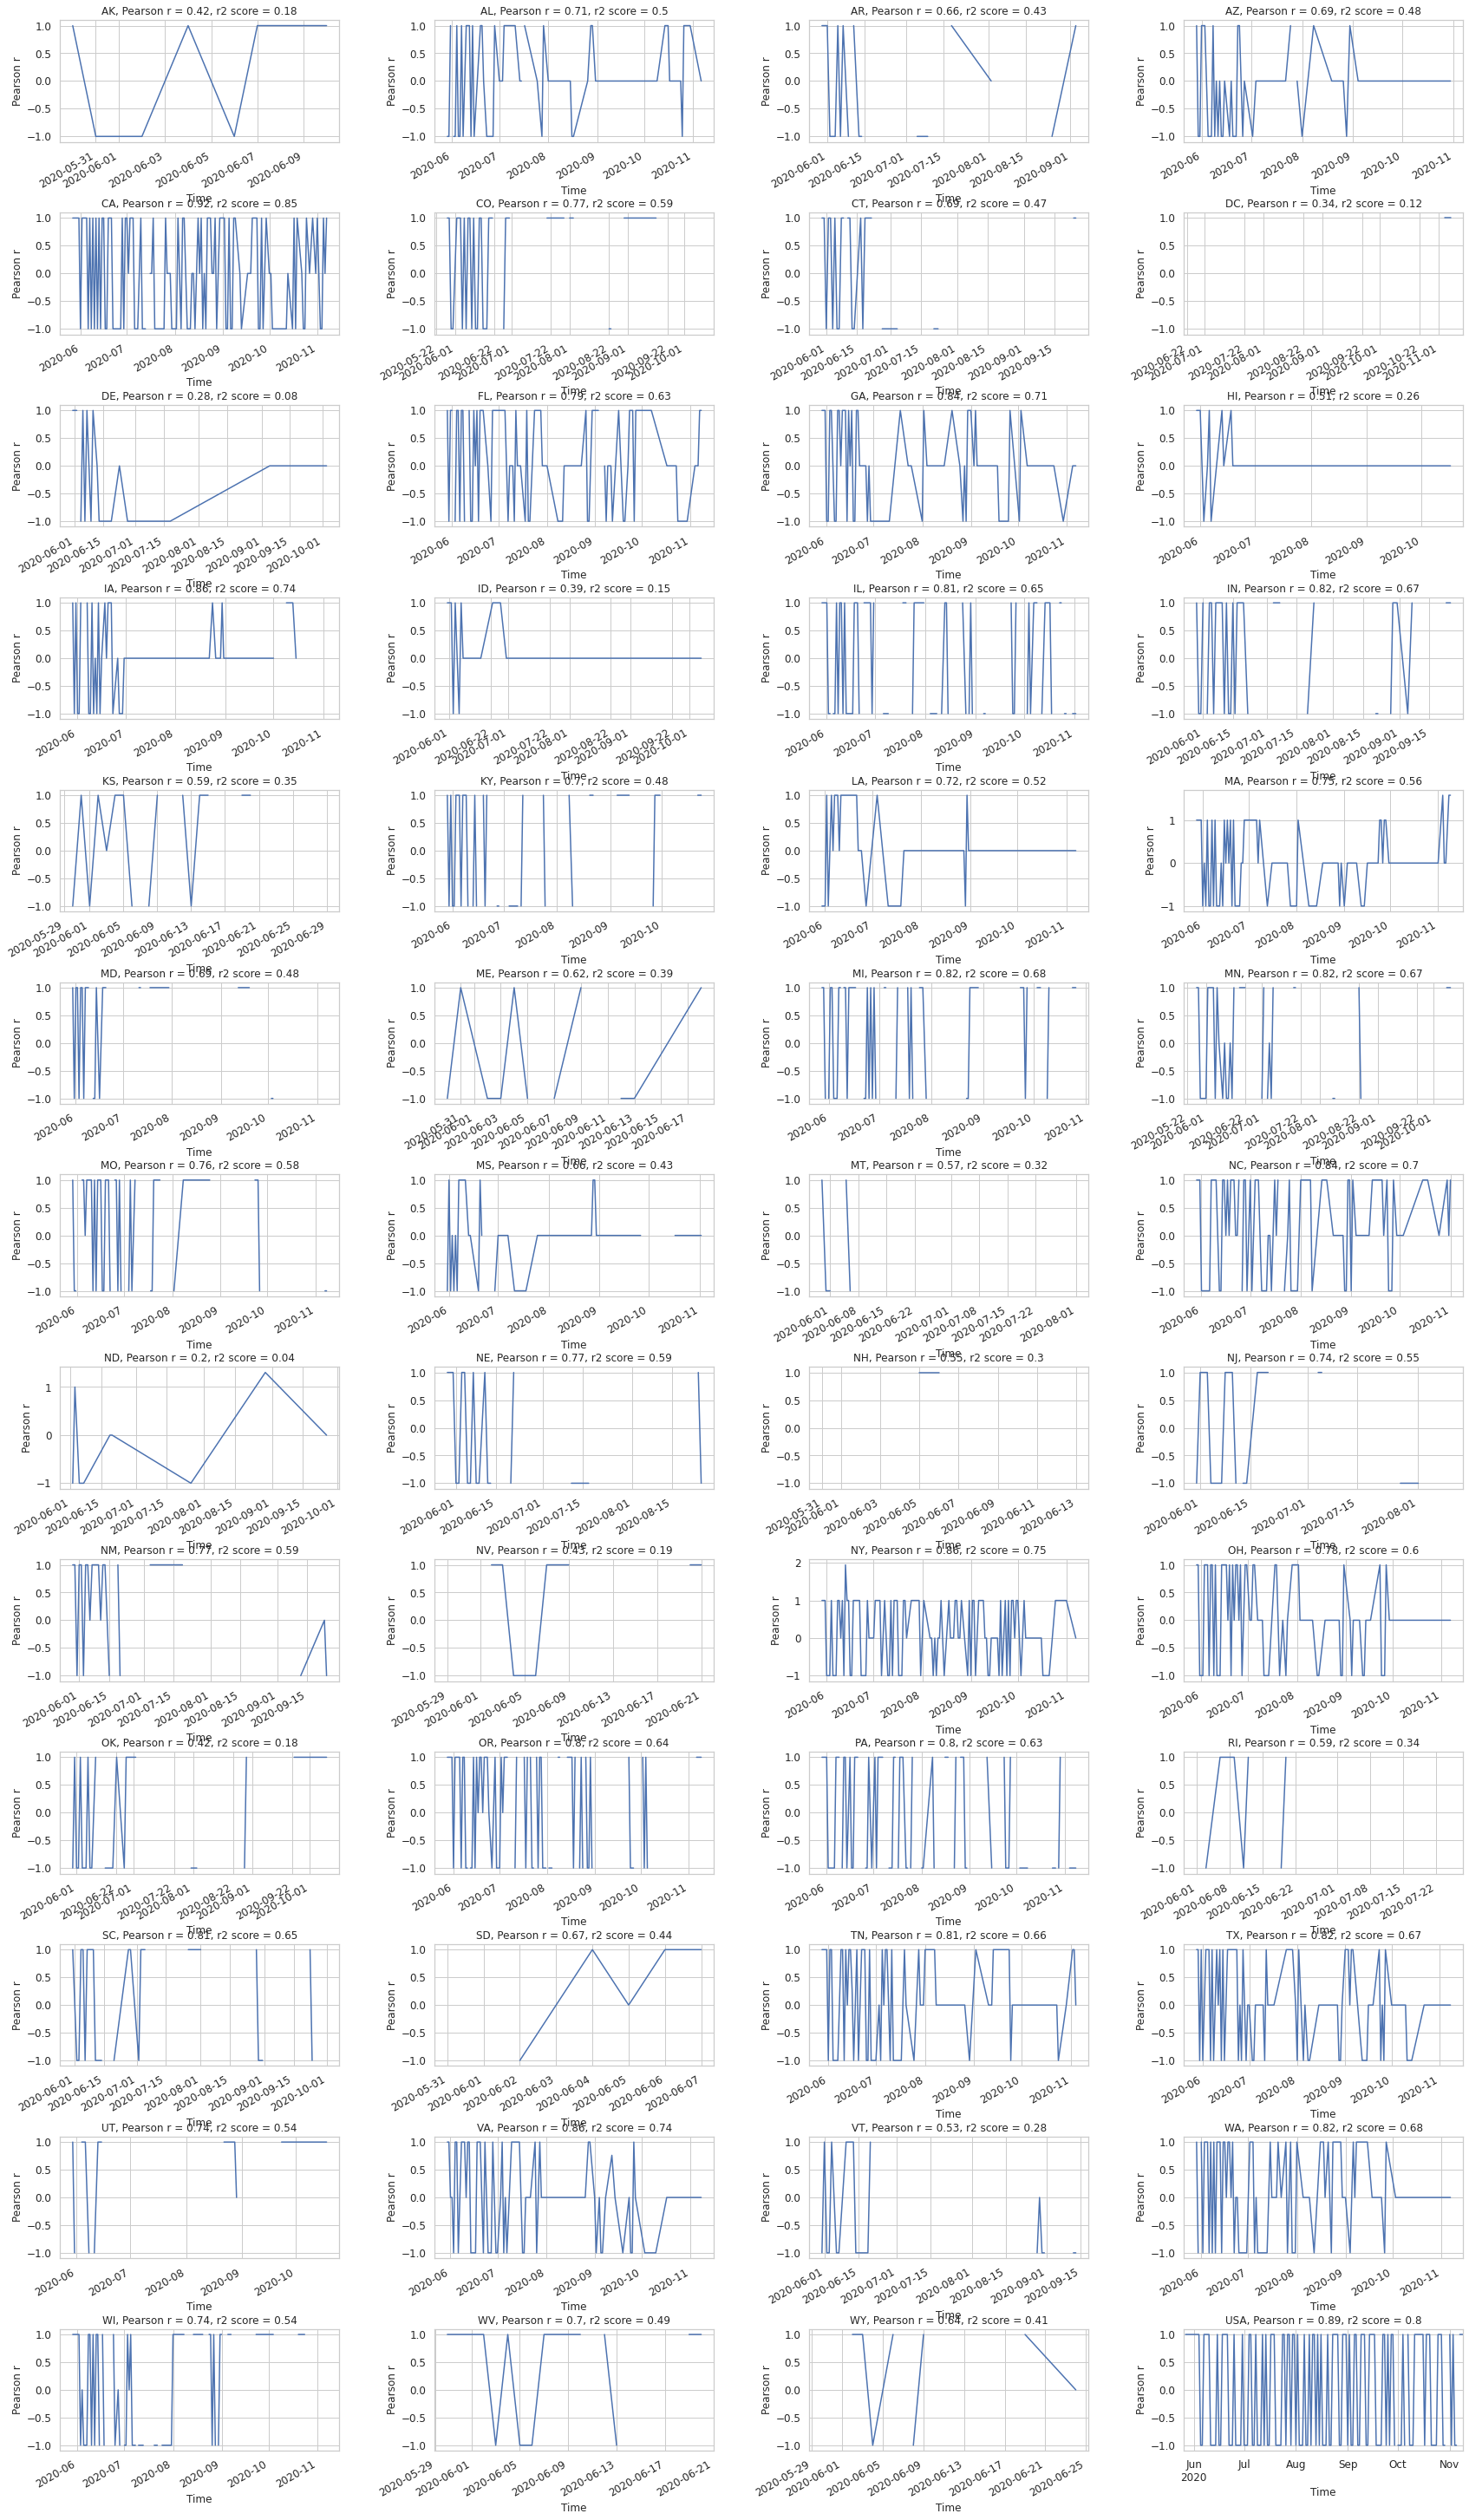

In [140]:
t_p = []
p_p = []
t_stat = []
p_stat = []
states = []
t_result = []
p_result = []

p_value = []
pearson_r = []
r2 = []

scaler = MinMaxScaler()

fig, axes = plt.subplots(13, 4, figsize=(25,50))
# fig.suptitle('3 rows x 4 columns axes with no data')
ax_num = 0
r_window_size = 2

fig.tight_layout(pad=6.0)

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

axes = axes.flatten()

for state in df['state'].unique():
    
    data = df[df['state']==state]
    states.append(state)
    # check distributions
    stat, p = stats.normaltest(data['tweet_count'])
    t_p.append(p)
    t_stat.append(stat)

    alpha = 0.05
    if p > alpha:
        t_result.append('Tweet data looks Gaussian (fail to reject null hypothesis)')
    else:
        t_result.append('Tweet data looks non-Gaussian (reject null hypothesis)')

    stat, p = stats.normaltest(data['protest_count'])
    p_p.append(p)
    p_stat.append(stat)
    
    alpha = 0.05
    if p> alpha:
        p_result.append('Protest data looks Gaussian (fail to reject null hypothesis)')
    else:
        p_result.append('Protest data looks non-Gaussian (reject null hypothesis)')
        
    data['tweet_count'] = scaler.fit_transform(data[['tweet_count']])
    data['protest_count'] = scaler.fit_transform(data[['protest_count']])

    # plot data

    r, p = stats.pearsonr(data.dropna()['tweet_count'], data.dropna()['protest_count'])
    
    p_value.append(p)
    pearson_r.append(r)
    r2.append(r**2)
    
    # Compute rolling window moving window synchrony.
#     f,ax=plt.subplots(figsize=(7,3))
#     df.rolling(window=1,center=True).median().plot(ax=axes[ax_num])
#     ax.set(xlabel='Time',ylabel='Pearson r')
#     ax.set(title=f"Pearson r = {np.round(r,2)}, r2 score = {np.round(r**2,2)}");

    # Interpolate missing data.
    df_interpolated = data.interpolate()
    # Compute rolling window synchrony
    rolling_r = df_interpolated['tweet_count'].rolling(window=r_window_size, center=True).corr(df_interpolated['protest_count'])
#     f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
#     data.rolling(window=1,center=True).median().plot(ax=ax[ax_num])
#     ax[0].set(xlabel='Time',ylabel='Tweets/protests')
    rolling_r.plot(ax=axes[ax_num])
    axes[ax_num].set(xlabel='Time',ylabel='Pearson r', title=f"{state}, Pearson r = {np.round(r,2)}, r2 score = {np.round(r**2,2)}")
    
#     plt.suptitle(f"Smiling data and rolling window correlation for {state}, overall metrics: Pearson r = {np.round(r,2)}, r2 score = {np.round(r**2,2)}")
    

    ax_num +=1
    
stat_dict = {"state": states, "tweet_pvalue": t_p, "protest_pvalue": p_p, "tweet_statistic": t_stat, 
             "protest_statistic": p_stat, "tweet_normresult": t_result, "protest_normresult": p_result, 
             "corr_p_value": p_value, "pearson_r": pearson_r, "r2": r2}

stat_df = pd.DataFrame.from_dict(stat_dict)

plt.savefig("../reports/figures/rollw_corr_state.png", dpi=300)
#         facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)

In [135]:
stat_df.to_csv("../data/raw/processed/stat_tests/state_normtest_corr_results.csv")

In [136]:
# stat_df

#### Check data distributions

In [58]:
stat,p = stats.normaltest(df['tweet_count'])
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Tweet data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Tweet data looks non-Gaussian (reject null hypothesis)')
# output: Statistics = 658.293, p=0.000 Data looks Gaussian (reject null hypothesis

Statistics = 135.797, p=0.000
Tweet data looks non-Gaussian (reject null hypothesis)


In [59]:
from scipy import stats
stat,p = stats.normaltest(df['protest_count'])
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Protest data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Protest data looks non-Gaussian (reject null hypothesis)')
# output: Statistics = 658.293, p=0.000 Data looks Gaussian (reject null hypothesis

Statistics = 154.165, p=0.000
Protest data looks non-Gaussian (reject null hypothesis)


#### 1. Pearson Correlation

In [64]:
scaler = MinMaxScaler()
# normalized
df['tweet_count'] = scaler.fit_transform(df[['tweet_count']])
df['protest_count'] = scaler.fit_transform(df[['protest_count']])

Pandas computed Pearson r: 0.8940668936521207
Scipy computed Pearson r: 0.8940668936521191 and p-value: 8.722845171050529e-60


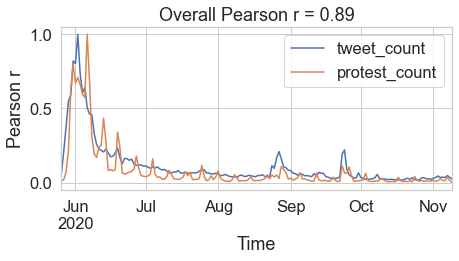

In [72]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

overall_pearson_r = df[df['state']=="USA"].corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(df[df['state']=="USA"].dropna()['tweet_count'], df[df['state']=="USA"].dropna()['protest_count'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df[df['state']=="USA"].rolling(window=1,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

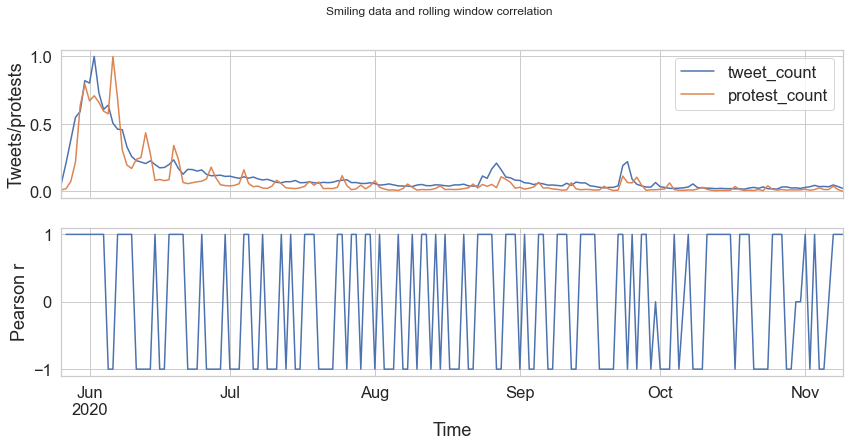

In [85]:
# Set window size to compute moving window synchrony.
r_window_size = 2
# Interpolate missing data.
df_interpolated = df[df['state']=="USA"].interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['tweet_count'].rolling(window=r_window_size, center=True).corr(df_interpolated['protest_count'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df[df['state']=="USA"].rolling(window=1,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Time',ylabel='Tweets/protests')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Time',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")

#### 2. Time Lagged Cross Correlation

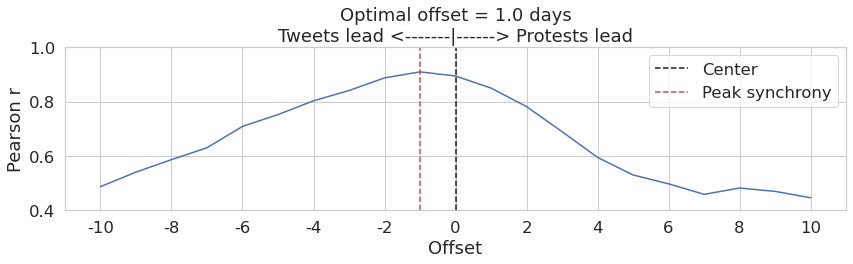

In [101]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    


d1 = df[df['state']=="USA"]['tweet_count']
d2 = df[df['state']=="USA"]['protest_count']
days = 10
rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Optimal offset = {offset} days\nTweets lead <-------|------> Protests lead',ylim=[0.4,1], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10,]);
plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

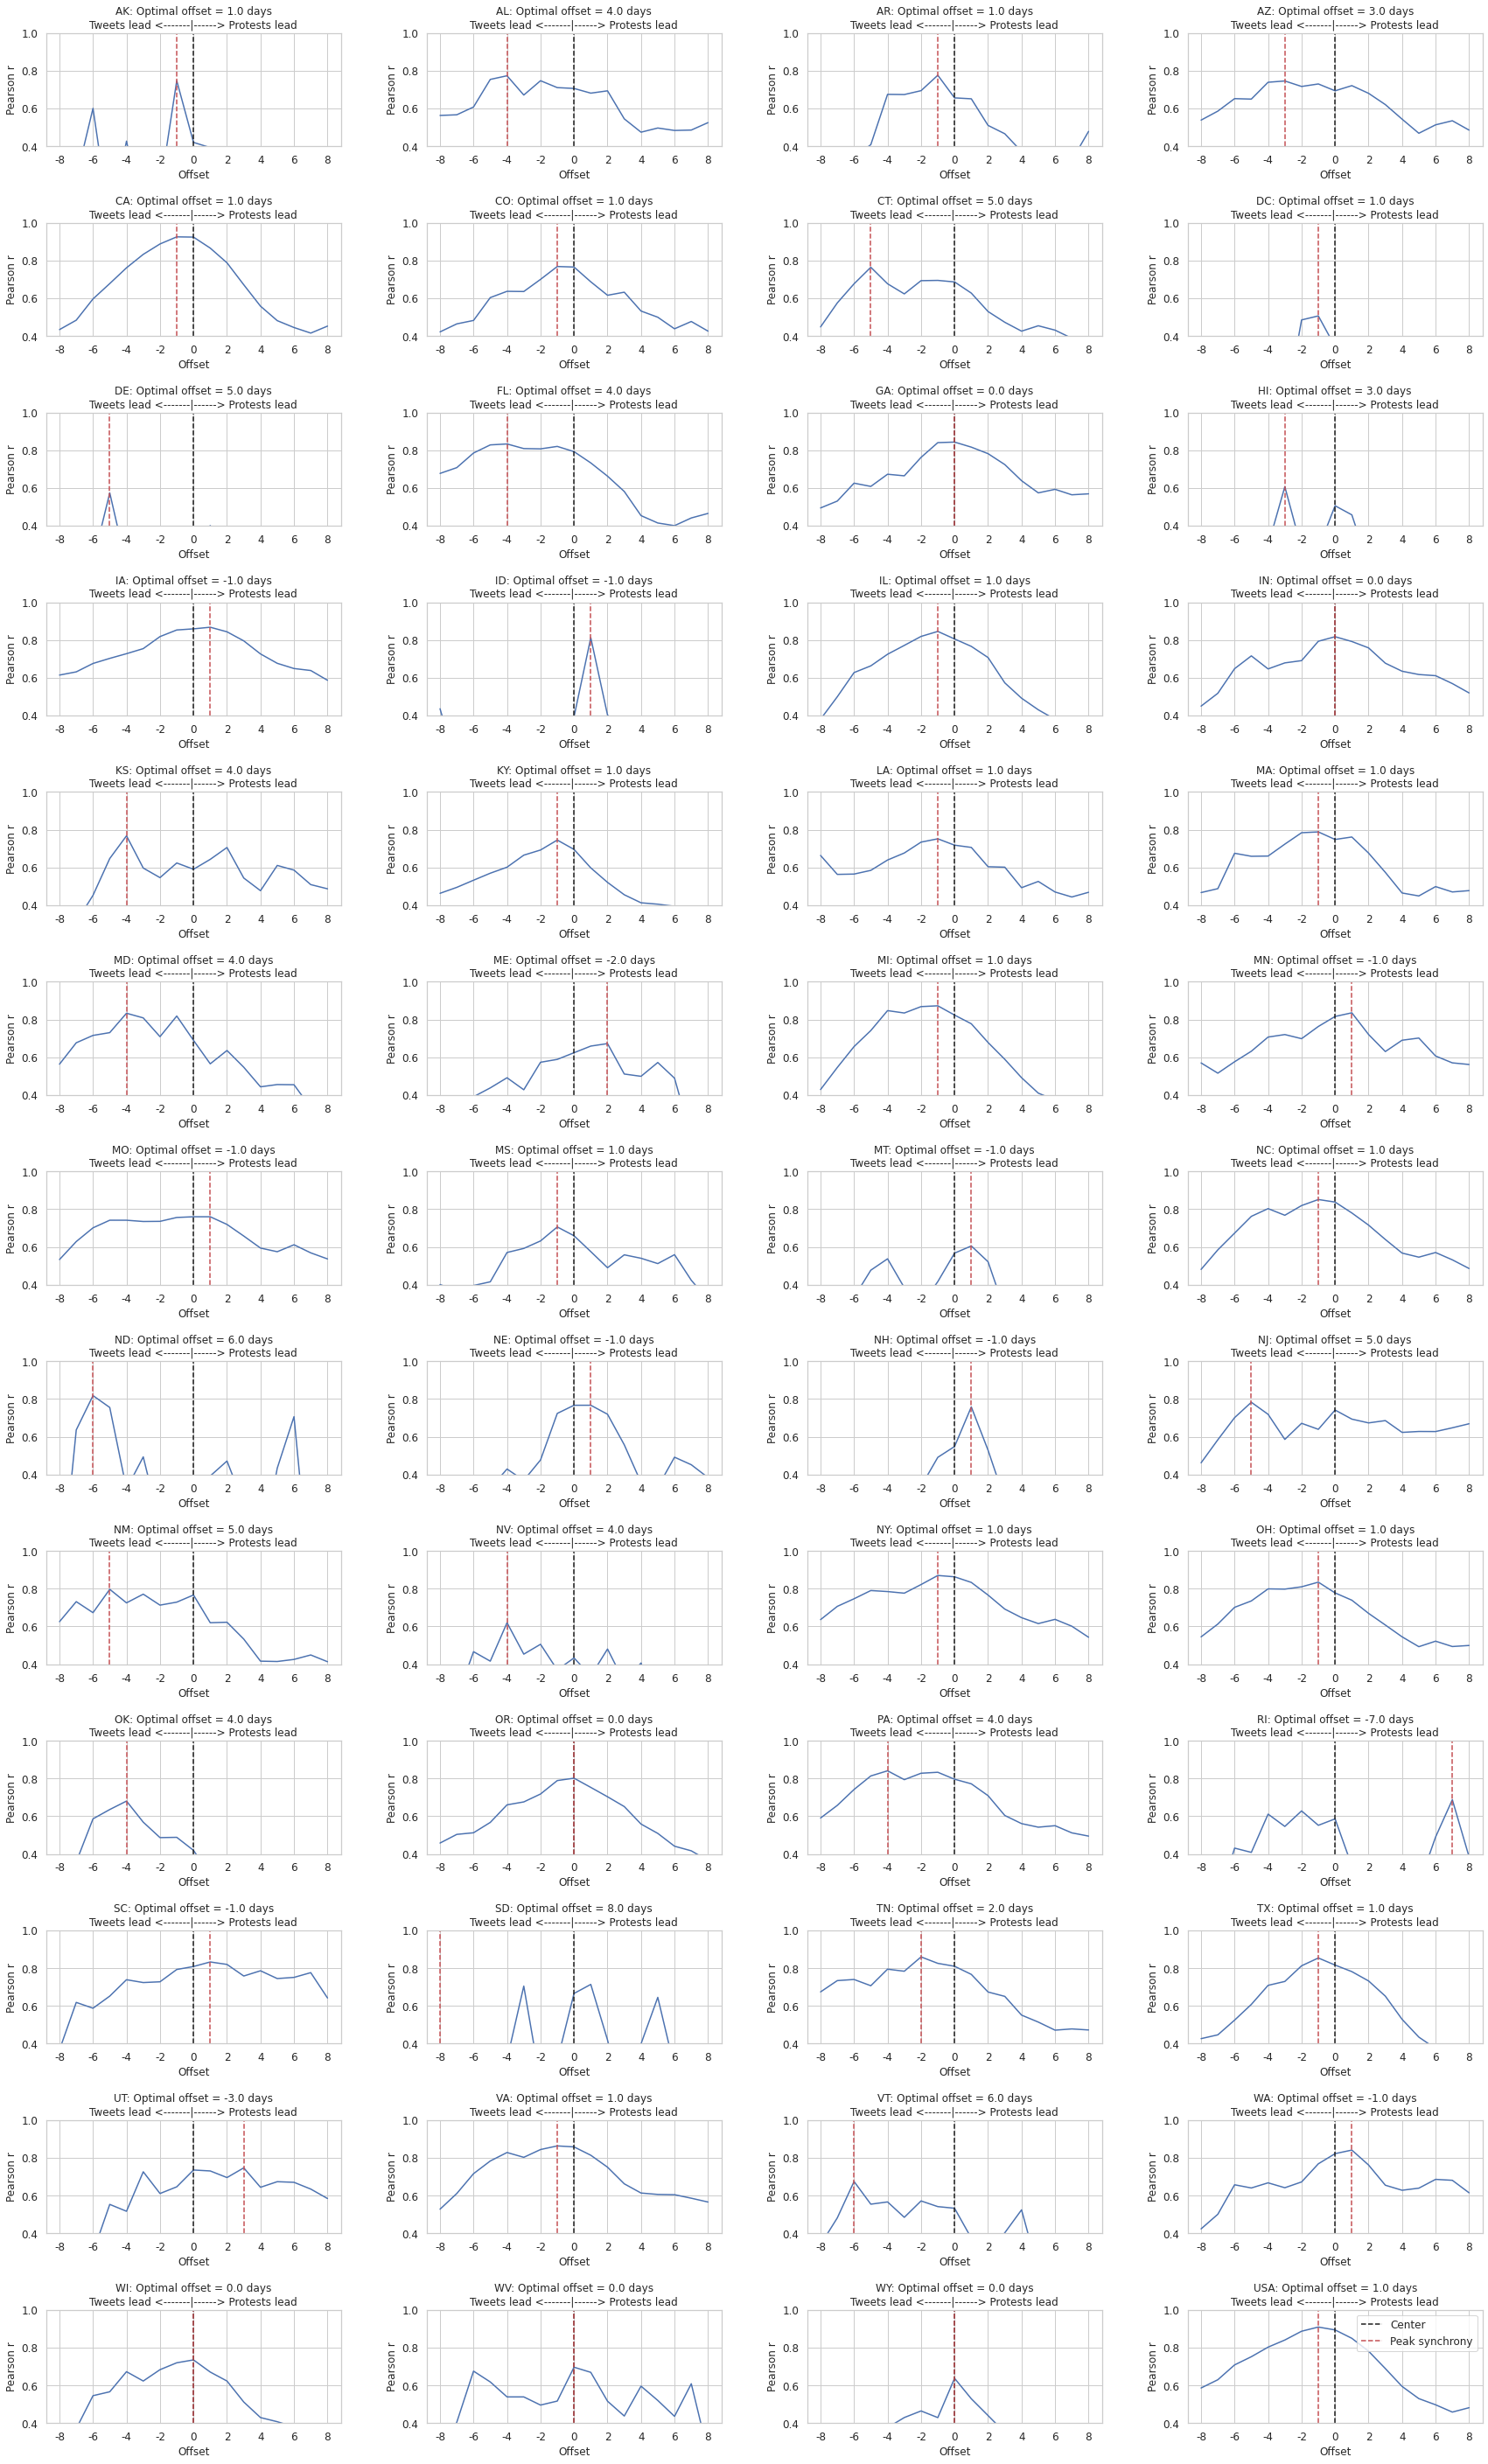

In [139]:
fig, axes = plt.subplots(13, 4, figsize=(25,40))
# fig.suptitle('3 rows x 4 columns axes with no data')
fig.tight_layout(pad=5.0)

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax_num = 0

axes = axes.flatten()

for state in df['state'].unique():
    
    data = df[df['state']==state]
    d1 = data['tweet_count']
    d2 = data['protest_count']
    days = 8
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
    offset = np.floor(len(rs)/2)-np.argmax(rs)
#     f,ax=plt.subplots(figsize=(14,3))
    axes[ax_num].plot(rs)
    axes[ax_num].axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
    axes[ax_num].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    axes[ax_num].set(title=f'{state}: Optimal offset = {offset} days\nTweets lead <-------|------> Protests lead',ylim=[0.4,1], xlabel='Offset',ylabel='Pearson r')
    axes[ax_num].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
    axes[ax_num].set_xticklabels([-8, -6, -4, -2, 0, 2, 4, 6, 8]);
    plt.legend()
    
    ax_num +=1
    
plt.savefig("../reports/figures/tlcross_corr_state.png", dpi=300)

#### Notes
- In 41 out of 51 states a better correlation is obtained when tweets lead by 1 or more days
- In all states, the highest correlations are obtained when levels of tweeting and protesting are above average (peak anomalies), but on "regular" days we obtain lower correlations. 

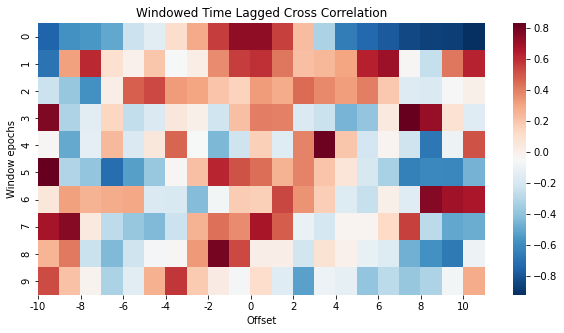

In [64]:
# Windowed time lagged cross correlation
days = 10
no_splits = 10
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = df['tweet_count'][int((t)*samples_per_split):int((t+1)*samples_per_split)]
    d2 = df['protest_count'][int((t)*samples_per_split):int((t+1)*samples_per_split)]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation', xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10,]);

# # Rolling window time lagged cross correlation
# days = 10
# window_size = 10 #samples
# t_start = 0
# t_end = t_start + window_size
# step_size = 30
# rss=[]
# while t_end < 5400:
#     d1 = df['S1_Joy'].iloc[t_start:t_end]
#     d2 = df['S2_Joy'].iloc[t_start:t_end]
#     rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(days),int(days+1))]
#     rss.append(rs)
#     t_start = t_start + step_size
#     t_end = t_end + step_size
# rss = pd.DataFrame(rss)

# f,ax = plt.subplots(figsize=(10,10))
# sns.heatmap(rss,cmap='RdBu_r',ax=ax)
# ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,301], xlabel='Offset',ylabel='Epochs')
# ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
# ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

#### 3. Dynamic Time Warping — synchrony of signals varying in lengths

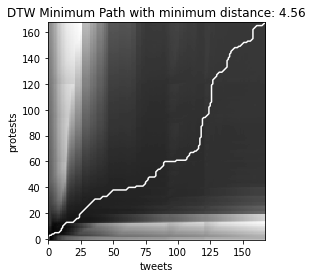

In [65]:
from dtw import dtw,accelerated_dtw

d1 = df['tweet_count'].interpolate().values
d2 = df['protest_count'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('tweets')
plt.ylabel('protests')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

### Granger Causality Analysis and Co-integration test
 
 Granger’s causality Tests the null hypothesis that the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (x) do not cause the other series (y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis. This has been performed on original data-set.

In [130]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=1

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(df[df['state']=="USA"][["tweet_count", "protest_count"]], variables = df.columns[:-1])  

,tweet_count_x,protest_count_x
tweet_count_y,1.0,0.6817
protest_count_y,0.0,1.0000


In [131]:
dfs = []
for state in df['state'].unique():
    data = df[df['state']==state]
    g_df = grangers_causality_matrix(data[["tweet_count", "protest_count"]], variables = data.columns[:-1])  
    g_df['state'] = state
    dfs.append(g_df)

granger_results = pd.concat(dfs)

In [133]:
granger_results.to_csv("../data/raw/processed/stat_tests/state_granger_results.csv")

In [217]:
print("For", len(granger_results[(granger_results['tweet_count_x']!=1)&(granger_results['tweet_count_x']==0)]), "states we can reject the null-hypothesis that tweet count does not cause protest count")

For 32 states we can reject the null-hypothesis that tweet count does not cause protest count


In [197]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

var = []
test_stat = []
c95 = []
signif = []

def cointegration_test(df_data, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df_data,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_data.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        var.append(adjust(col))
        test_stat.append(adjust(round(trace,2), 9))
        c95.append(adjust(cvt, 8))
        signif.append(trace > cvt)
        
    coint_df = pd.DataFrame.from_dict({"variable":var, "test_statistic":test_stat, "C(95%)":c95, "signif":signif})  
    return coint_df



coint_df = cointegration_test(df[df['state']=="OK"][["tweet_count", "protest_count"]])
coint_df

,variable,test_statistic,C(95%),signif
0,tweet_count,40.75,12.3212,True
1,protest_count,14.24,4.1296,True


In [198]:
var = []
test_stat = []
c95 = []
signif = []
state = []
dfs = []

for state in df['state'].unique():
    data = df[df['state']==state]
#     state.append(state)
#     coint = np.NaN
    coint_result = cointegration_test(data[["tweet_count", "protest_count"]])
    coint_result['state'] = state
#     print(coint.iloc[-2:, :])
    dfs.append(coint_result.iloc[-2:, :])
    
coint_df = pd.concat(dfs)

In [195]:
coint_df.to_csv("../data/raw/processed/stat_tests/cointegration_results.csv")

In [210]:
coint_df[coint_df['signif']==True]

,variable,test_statistic,C(95%),signif,state
0,tweet_count,24.64,12.3212,True,AK
1,protest_count,6.13,4.1296,True,AK
2,tweet_count,40.58,12.3212,True,AL
3,protest_count,6.68,4.1296,True,AL
4,tweet_count,43.85,12.3212,True,AR
...,...,...,...,...,...
97,protest_count,11.8,4.1296,True,WI
98,tweet_count,32.16,12.3212,True,WV
100,tweet_count,32.56,12.3212,True,WY
102,tweet_count,52.21,12.3212,True,USA


In [205]:
# basic cointegration
coint(df[df['state']=="USA"]["tweet_count"], df[df['state']=="USA"]["protest_count"], trend='c', method='aeg', maxlag=None, autolag='aic', return_results=None)

(-2.1967408099987336,
 0.42604484183331315,
 array([-3.9632224 , -3.37296207, -3.06994394]))

### Vector Auto Regressive Model

In [67]:
n_obs=40
X_train, X_test = df[0:-n_obs], df[-n_obs:]
print(X_train.shape, X_test.shape)

(128, 2) (40, 2)


In [111]:
nobs = 15
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(153, 2)
(15, 2)


In [118]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [119]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "tweet_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9334
 No. Lags Chosen       = 2
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0416. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "protest_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.3784
 No. Lags Chosen       = 12
 Critical value 1%     = -3.478
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [120]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [121]:
model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -11.616429391197299
BIC :  -11.50440566140987
FPE :  9.016794534452297e-06
HQIC:  -11.570961425059412 

Lag Order = 2
AIC :  -11.870073342673654
BIC :  -11.682604198796755
FPE :  6.996945317625991e-06
HQIC:  -11.793978363366035 

Lag Order = 3
AIC :  -12.08332019332248
BIC :  -11.819785425840006
FPE :  5.653598711676373e-06
HQIC:  -11.976342266545878 

Lag Order = 4
AIC :  -12.632448922462304
BIC :  -12.292219680384038
FPE :  3.265073896956618e-06
HQIC:  -12.49432869956276 

Lag Order = 5
AIC :  -12.763904574440872
BIC :  -12.346343197644867
FPE :  2.8634205020433643e-06
HQIC:  -12.594379231821941 

Lag Order = 6
AIC :  -13.076724037411564
BIC :  -12.581183884843403
FPE :  2.0948421452121146e-06
HQIC:  -12.875527214660911 

Lag Order = 7
AIC :  -13.310534635328885
BIC :  -12.736359908934265
FPE :  1.6587426271667715e-06
HQIC:  -13.077396372030023 

Lag Order = 8
AIC :  -13.975335533271256
BIC :  -13.321861097534068
FPE :  8.536664197620434e-07
HQIC:  -13.7099822044

C:\Users\Leonardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [122]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-11.47,-11.43,1.042e-05,-11.46
1,-14.13,-14.02,7.270e-07,-14.09
2,-14.47,-14.27,5.202e-07,-14.39
3,-14.49,-14.21,5.104e-07,-14.38
4,-14.67,-14.32,4.258e-07,-14.53
5,-14.72,-14.29,4.044e-07,-14.55
6,-14.91,-14.40,3.362e-07,-14.70
7,-15.26,-14.67*,2.364e-07*,-15.02*
8,-15.25,-14.59,2.383e-07,-14.98
9,-15.21,-14.47,2.488e-07,-14.91


In [140]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, May, 2021
Time:                     03:11:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5044
Nobs:                     167.000    HQIC:                  -11.5710
Log likelihood:           502.046    FPE:                9.01679e-06
AIC:                     -11.6164    Det(Omega_mle):     8.70136e-06
--------------------------------------------------------------------
Results for equation tweet_count
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.004075         0.004468            0.912           0.362
L1.tweet_count           0.963001         0.050595           19.034           0.000
L1.protest_count        -0.008617         

In [141]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

tweet_count : 1.61
protest_count : 1.64


In [142]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df.values[-lag_order:]
forecast_input

1


array([[0.00598754, 0.        ]])

In [143]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,tweet_count_2d,protest_count_2d
date,,
2020-10-26,0.009841,-0.004700
2020-10-27,0.013592,-0.004261
2020-10-28,0.017201,-0.002061
2020-10-29,0.020658,0.000682
2020-10-30,0.023962,0.003535
2020-10-31,0.027120,0.006344
2020-11-01,0.030137,0.009057
2020-11-02,0.033019,0.011660
2020-11-03,0.035772,0.014150


In [144]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [145]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results

,tweet_count_2d,protest_count_2d,tweet_count_1d,tweet_count_forecast,protest_count_1d,protest_count_forecast
date,,,,,,
2020-10-26,0.009841,-0.004700,0.008970,0.011256,-0.030423,-0.025600
2020-10-27,0.013592,-0.004261,0.022563,0.033819,-0.034684,-0.060284
2020-10-28,0.017201,-0.002061,0.039764,0.073583,-0.036745,-0.097029
2020-10-29,0.020658,0.000682,0.060421,0.134004,-0.036063,-0.133092
2020-10-30,0.023962,0.003535,0.084384,0.218388,-0.032527,-0.165619
2020-10-31,0.027120,0.006344,0.111504,0.329892,-0.026184,-0.191803
2020-11-01,0.030137,0.009057,0.141642,0.471534,-0.017126,-0.208929
2020-11-02,0.033019,0.011660,0.174661,0.646195,-0.005467,-0.214396
2020-11-03,0.035772,0.014150,0.210433,0.856628,0.008683,-0.205713


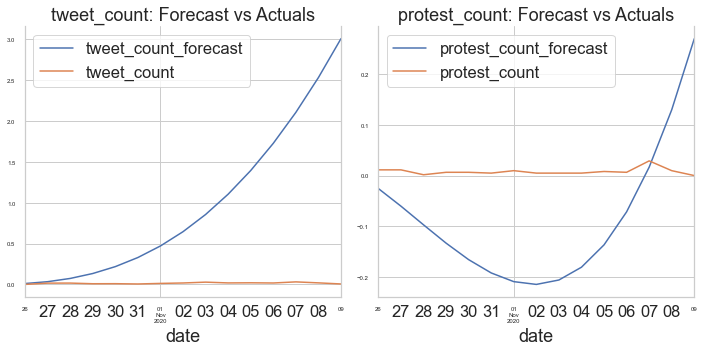

In [146]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2,  figsize=(10,5)) #dpi=150,
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

df

### Multivariate LSTM Forecast Model

### 1. Prepare data for modelling
We will frame the supervised learning problem as predicting the number of physical protests at the current day (t) given the number of physical protests and number of tweets at the prior time step.

In [174]:
# tweets_geo = gpd.read_file("../data/raw/processed/tweets_gdf_fs.geojson")
# protest data
# df_p = pd.read_excel("../data/raw/protests/USA_2020_2021_Feb12.xlsx")
# df_p['protest_count'] = 1
# df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'])
# df_p = df_p[(df_p['ASSOC_ACTOR_1'] == "BLM: Black Lives Matter")&(df_p['EVENT_DATE'] > "2020-05-25")]

In [295]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM

 
# load dataset
dataset = df_p_t.iloc[:,3:]
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = DataFrame(scaler.fit_transform(values))
scaled.columns = dataset.columns
# # frame as supervised learning
# reframed = series_to_supervised(scaled, 1, 1)
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
scaled.head(10)

,tweet_count,protest_count,protest_count_lag1,protest_count_lag2,protest_count_lag3,protest_count_lag4,protest_count_lag5,protest_count_lag6,protest_count_lag7,tweet_count_lag1,tweet_count_lag2,tweet_count_lag3,tweet_count_lag4,tweet_count_lag5,tweet_count_lag6,tweet_count_lag7
0,0.045669,0.009646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.199820,0.020900,0.009646,NaN,NaN,NaN,NaN,NaN,NaN,0.045669,NaN,NaN,NaN,NaN,NaN,NaN
2,0.370030,0.070740,0.020900,0.009646,NaN,NaN,NaN,NaN,NaN,0.199820,0.045669,NaN,NaN,NaN,NaN,NaN
3,0.541355,0.221865,0.070740,0.020900,0.009646,NaN,NaN,NaN,NaN,0.370030,0.199820,0.045669,NaN,NaN,NaN,NaN
4,0.585227,0.588424,0.221865,0.070740,0.020900,0.009646,NaN,NaN,NaN,0.541355,0.370030,0.199820,0.045669,NaN,NaN,NaN
5,0.817652,0.744373,0.588424,0.221865,0.070740,0.020900,0.009646,NaN,NaN,0.585227,0.541355,0.370030,0.199820,0.045669,NaN,NaN
6,0.799336,0.604502,0.744373,0.588424,0.221865,0.070740,0.020900,0.009646,NaN,0.817652,0.585227,0.541355,0.370030,0.199820,0.045669,NaN
7,1.000000,0.673633,0.604502,0.744373,0.588424,0.221865,0.070740,0.020900,0.009646,0.799336,0.817652,0.585227,0.541355,0.370030,0.199820,0.045669
8,0.727213,0.588424,0.673633,0.604502,0.744373,0.588424,0.221865,0.070740,0.020900,1.000000,0.799336,0.817652,0.585227,0.541355,0.370030,0.199820
9,0.600196,0.508039,0.588424,0.673633,0.604502,0.744373,0.588424,0.221865,0.070740,0.727213,1.000000,0.799336,0.817652,0.585227,0.541355,0.370030


In [299]:
# split into train and test sets
p_lag = ""
t_lag = "" #"_lag1"
values = scaled[[f'tweet_count{t_lag}', f'protest_count{p_lag}']].values
n_train_days = 100
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(f"Training: \tX.shape: {train_X.shape}, \tY.shape: {train_y.shape}")
print(f"Validation:\tX.shape: {test_X.shape}, \tY.shape: {test_y.shape}")

(100, 1, 1) (100,) (68, 1, 1) (68,)
Training: 	X.shape: (100, 1, 1), 	Y.shape: (100,)
Validation:	X.shape: (68, 1, 1), 	Y.shape: (68,)


In [270]:
# scaled[[f'tweet_count{t_lag}', f'protest_count{p_lag}']]

In [248]:
# train_X

### 2. Define and Fit Model
Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [283]:
# Function for model creation
# def FNNmodel(n_hidden_neurons=10, dropout_rate=0.1):
#   i = Input(shape=(T,))      
#   x = Dense(neurons, activation='sigmoid', name='Hidden_layer')(i)
#   x = Dropout(dropout_rate)(x)
#   x = Dense(1, activation='sigmoid', name='Output')(x)  
#   model = Model(i,x)
#   return model

def RNNmodel(n_hidden_neurons=10, cell_type='LSTM', dropout_rate=0.2):
    i = Input(shape=(train_X.shape[1], train_X.shape[2]))
    if cell_type == 'SimpleRNN':
        x = SimpleRNN(n_hidden_neurons, activation='tanh', return_sequences=False, name='SimpleRNN')(i)
    elif cell_type == 'LSTM':
        x = LSTM(n_hidden_neurons, activation='tanh', name='LSTM')(i)
    else:
        raise Exception("Error: Cell type not recognized! Choose between 'SimpleRNN','LSTM', or 'GRU'.")    
    x = Dropout(dropout_rate)(x)
    x = Dense(1, activation='sigmoid', name='Output')(x)
    model = Model(i,x)
    return model

In [278]:
train_X.shape[0], train_X.shape[1]

(100, 1)

In [227]:
Input(shape=(train_X.shape[0], train_X.shape[1]))

<tf.Tensor 'input_7:0' shape=(None, 100, 1) dtype=float32>

In [284]:
# ANN_type = ['SimpleRNN','LSTM']
# neurons = [10,25]
# dropout_rate = [0,0.25]
lr = 0.0001#[0.0001]
# batch_size = [16]

# all_combinations = list(itertools.product(*[ANN_type,neurons,dropout_rate,lr,batch_size]))
# print(pd.DataFrame(data=all_combinations, columns=['ann_type','neurons','dropout_rate','lr','batch_size']))
# model = RNNmodel(neurons, cell_type=ANN_type, dropout_rate=dropout_rate)
model = RNNmodel(50, cell_type="LSTM", dropout_rate=0)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [304]:
import tensorflow
tensorflow.keras.backend.clear_session()
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [1]:
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
# pyplot.plot(history.history['accuracy'], label='train')
# pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'model' is not defined

In [187]:
# scaled[[f'tweet_count{lag}', f'protest_count{lag}']]